#### Import Library

In [17]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score

#### Load Data

In [2]:
df = pd.read_csv('dataset/personality_dataset.csv')
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


#### Split Dataset

In [4]:
X = df.drop(columns=['Personality'])
y = df['Personality'].apply(lambda x: 1 if x == 'Introvert' else 0)

In [5]:
feature_train, feature_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Column Categories

In [6]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

#### EDA (Exploratory Data Analysis)

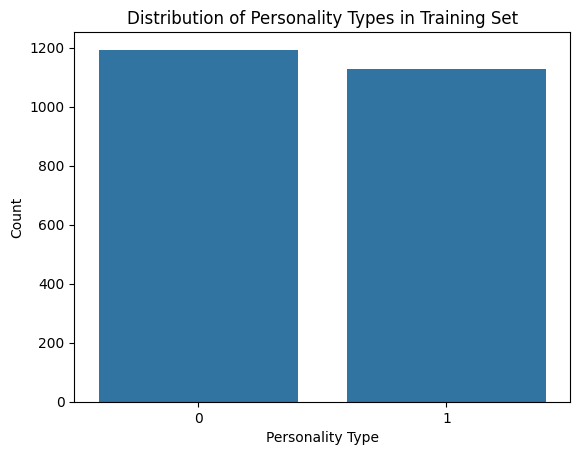

In [7]:
sns.countplot(x=target_train)
plt.title('Distribution of Personality Types in Training Set')
plt.xlabel('Personality Type')
plt.ylabel('Count')
plt.show()

##### Missing Values

In [8]:
missing_values = feature_train.isnull().sum()
print("Missing values in training features:\n", missing_values[missing_values > 0])

Missing values in training features:
 Time_spent_Alone             52
Stage_fear                   58
Social_event_attendance      45
Going_outside                54
Drained_after_socializing    40
Friends_circle_size          62
Post_frequency               50
dtype: int64


##### Descriptive stats for numerical features

In [9]:
feature_train.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2268.000000,2275.000000,2266.000000,2258.000000,2270.000000
mean,4.500441,3.973626,3.015004,6.317095,3.572687
std,3.498377,2.908485,2.246753,4.311578,2.918876
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,4.000000,3.000000,5.000000,3.000000
75%,8.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


##### Histograms for numerical features

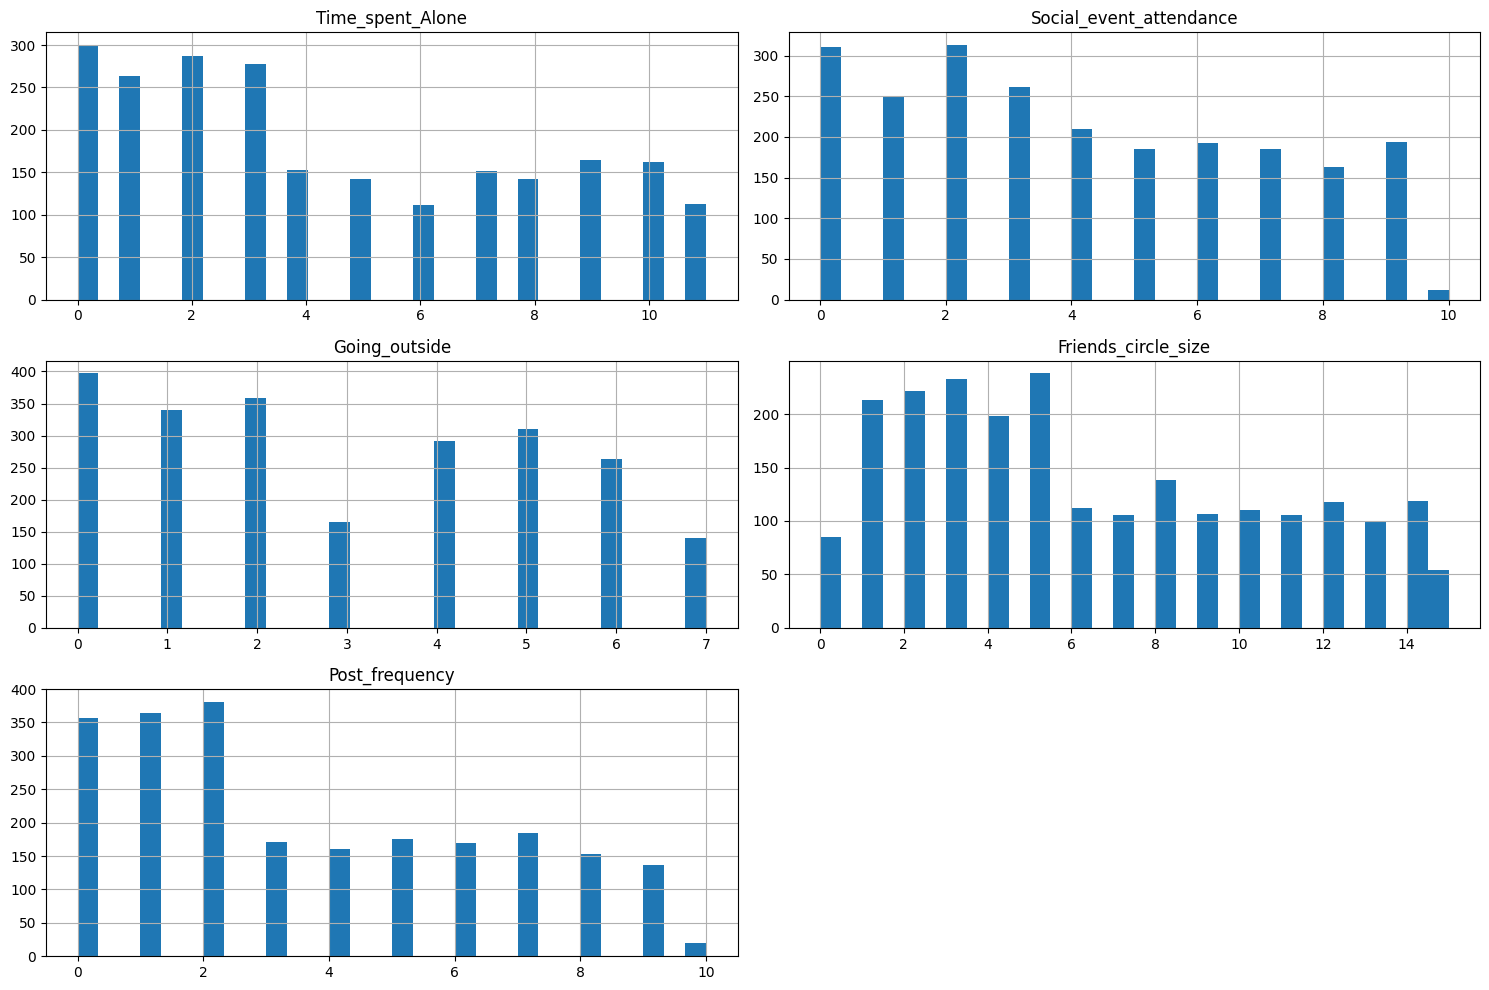

In [10]:
feature_train[numerical_features].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

##### Correlation Matrix

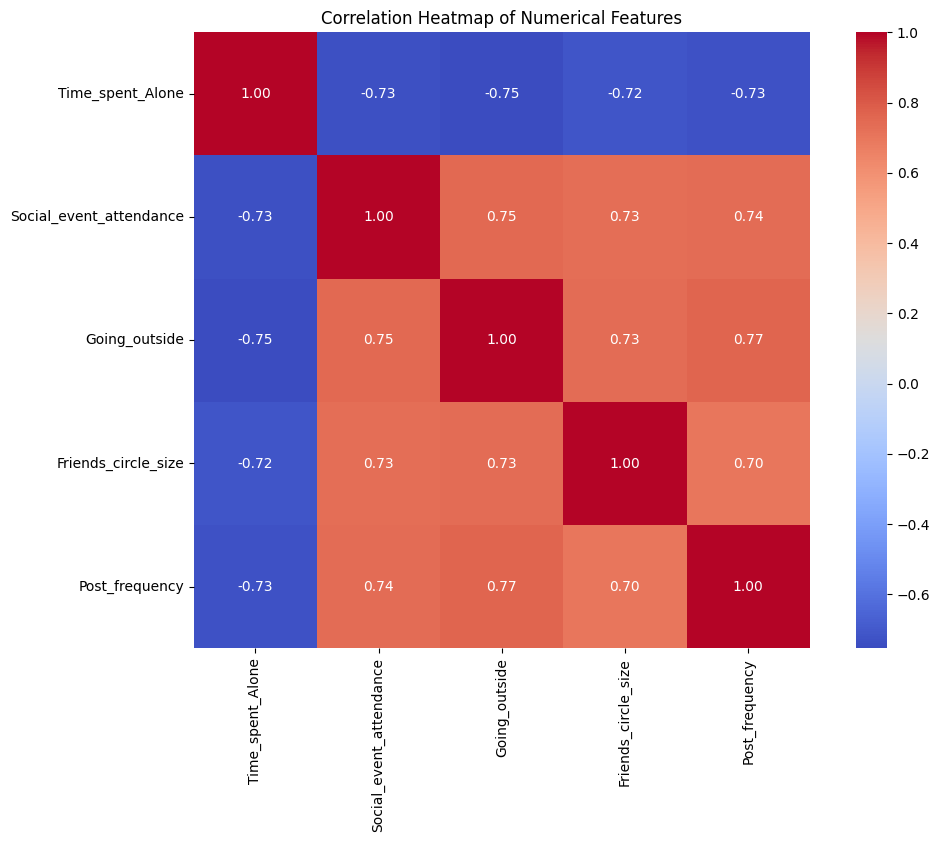

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(feature_train[numerical_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

#### Preprocessing Pipeline

In [19]:
num_pipeline_scaled = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_pipeline_no_scaler = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor_scaled = ColumnTransformer([
    ('num', num_pipeline_scaled, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

preprocessor_no_scaler = ColumnTransformer([
    ('num', num_pipeline_no_scaler, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])



#### Define Models

In [20]:
# Model 1: Logistic Regression
pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('classifier', LogisticRegression())
])

# Model 2: SVM
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('classifier', SVC())
])

# Model 3: Decision Tree
pipeline_tree = Pipeline([
    ('preprocessor', preprocessor_no_scaler),
    ('classifier', DecisionTreeClassifier())
])

# Model 4: XGBoost
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor_no_scaler),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])


#### Cross Validation And Evaluation

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1 = make_scorer(f1_score, pos_label=1)

model_names = []
score_f1 = []

pipelines = {
    'Logistic Regression': pipeline_logreg,
    'SVM': pipeline_svm,
    'Decision Tree': pipeline_tree,
    'XGBoost': pipeline_xgb
}

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, feature_train, target_train, cv=cv, scoring=f1)
    model_names.append(name)
    score_f1.append(scores.mean())
    print(f"{name} Mean F1-score: {scores.mean():.4f}")



Logistic Regression Mean F1-score: 0.9276
SVM Mean F1-score: 0.9375
Decision Tree Mean F1-score: 0.8775
XGBoost Mean F1-score: 0.9234


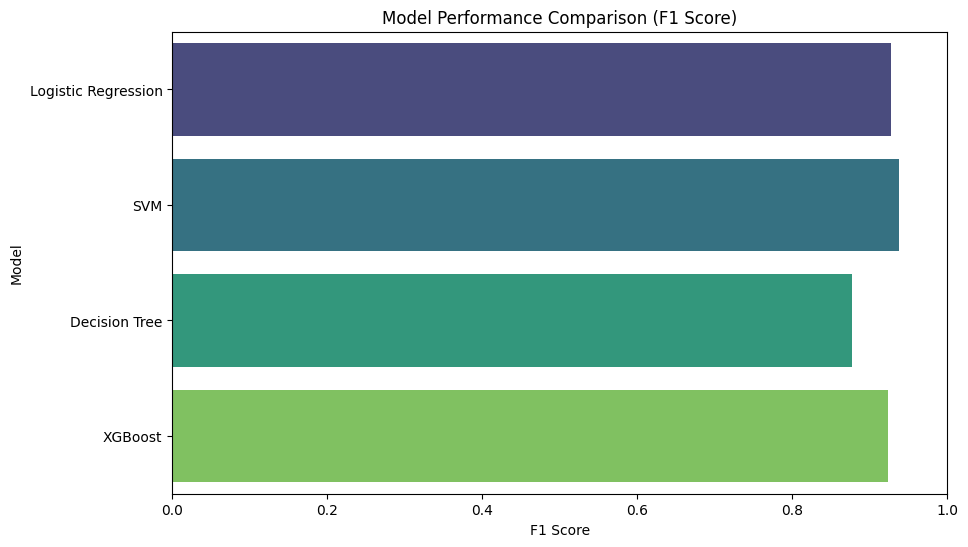

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x=score_f1, y=model_names, palette='viridis')
plt.title('Model Performance Comparison (F1 Score)')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.show()

##### Final Model Selection & Evaluation On Test Set

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       298
           1       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



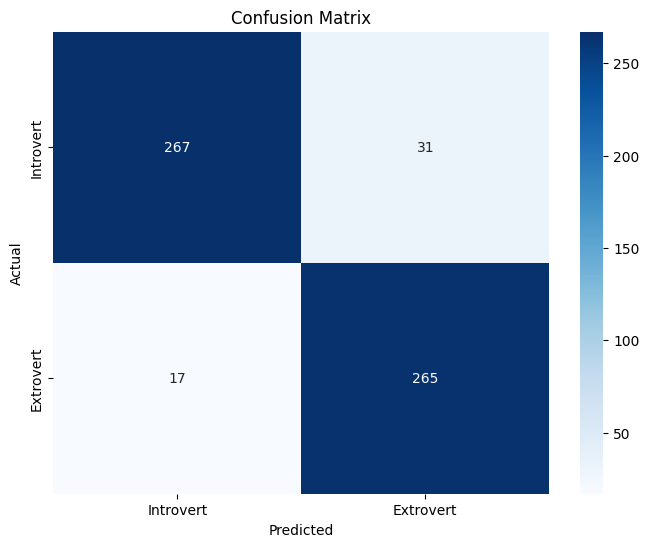

In [23]:
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_scaled),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])

final_pipeline.fit(feature_train, target_train)
y_pred = final_pipeline.predict(feature_test)
print("Classification Report:\n", classification_report(target_test, y_pred))
cm = confusion_matrix(target_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Introvert', 'Extrovert'], yticklabels=['Introvert', 'Extrovert'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 🧾 Final Evaluation Summary
After training and evaluating multiple classification models using cross-validation, the Support Vector Machine (SVM) with RBF kernel was selected as the final model due to its consistently strong performance.

On the held-out test set, the SVM model achieved the following results:

Accuracy: 92%

F1-score for both classes (Introvert & Extrovert): 0.92

Precision & Recall: Balanced across both classes, indicating no major bias.

Confusion Matrix:

True Introverts correctly classified: 267

True Extroverts correctly classified: 265

False Positives: 31

False Negatives: 17

These results indicate that the model generalizes well and does not suffer from overfitting, as its performance on the test set is consistent with the cross-validation score (mean F1-score ≈ 0.9375 during training).

The model shows strong reliability in predicting personality types, and it is suitable for deployment or further use in applications requiring personality classification.